In [36]:
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
enable_eager_execution()

import os
import numpy as np
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow imports
from tensorflow import int32
from tensorflow.keras import regularizers
from tensorflow.keras.backend import placeholder
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Add
import tensorflow.keras.backend as K
import tensorflow as tf
import re
import nltk
from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)


Number of replicas: 1


In [37]:
train_df = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test_df = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
len(train_df)

12120

In [38]:
train_df = train_df[train_df['language'] == 'English']
test_df = test_df[test_df['language'] == 'English']
len(train_df)

6870

In [39]:
temp = pd.DataFrame()
temp['premise'] = train_df['premise']
temp['hypothesis'] = train_df['hypothesis']

In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

temp['premise'] =  temp['premise'].apply(clean_sentence)
temp['hypothesis'] =  temp['hypothesis'].apply(clean_sentence)


In [42]:
def build_corpus(data):
    corpus = []
    for col in ['premise', 'hypothesis']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(temp)        


In [43]:
def tsne_plot(model, word_limit=100):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in list(model.wv.key_to_index)[:word_limit]:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


In [44]:
encoder = word2vec.Word2Vec(corpus, vector_size=100, window=20, min_count=2, workers=8)

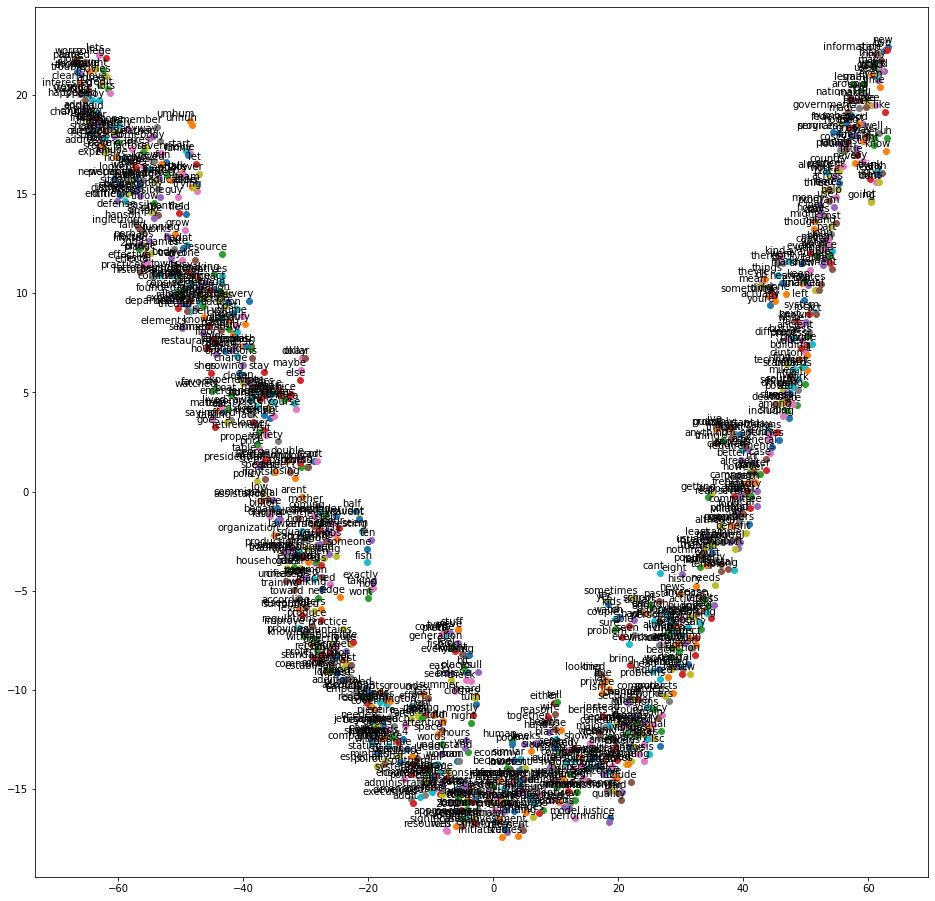

In [45]:
tsne_plot(encoder, word_limit=1000)

In [46]:
result = []
for word in np.concatenate(corpus):
    if word in encoder.wv:
        result.append(1)
    else:
        result.append(0)
        
print("%d/%d" % (sum(result), len(result)))

def encode_f(sentence):
    words = sentence.lower().split()
    result = []
    for word in words:
        if word in encoder.wv:
            result.append(encoder.wv[word])
    return result

train_df.premise = train_df.premise.apply(encode_f)
train_df.hypothesis = train_df.hypothesis.apply(encode_f)

test_df.premise = test_df.premise.apply(encode_f)
test_df.hypothesis = test_df.hypothesis.apply(encode_f)

105805/108414


In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_x1 = pad_sequences(train_df.premise.to_numpy(), dtype='float', maxlen=70)
train_x2 = pad_sequences(train_df.hypothesis.to_numpy(), dtype='float', maxlen=70)
train_y = train_df.label.to_numpy()

test_x1 = pad_sequences(test_df.premise.to_numpy(), dtype='float', maxlen=70)
test_x2 = pad_sequences(test_df.hypothesis.to_numpy(), dtype='float', maxlen=70)

In [48]:
print(train_df.premise.to_numpy()[0])
print(train_x1[0])

[array([-0.13098302,  0.3279007 ,  0.15669976,  0.00148891,  0.13613273,
       -0.5873638 ,  0.0323757 ,  0.740791  , -0.2096427 , -0.16963995,
       -0.22927661, -0.62670386,  0.06169765,  0.22241515,  0.20624714,
       -0.24514204,  0.09847666, -0.34647802,  0.03395416, -0.74088293,
        0.14643665,  0.1052968 ,  0.27645195, -0.17025274,  0.03560799,
        0.06508161, -0.1133705 , -0.19929604, -0.5131268 ,  0.04228099,
        0.34964597, -0.0489376 ,  0.01025021, -0.18922603, -0.06675819,
        0.3940399 ,  0.12878315, -0.32699662, -0.17818733, -0.55485266,
       -0.00981994, -0.29249933, -0.12575714,  0.1067784 ,  0.29196167,
       -0.18095355, -0.4764856 ,  0.10213614,  0.1239346 ,  0.19094317,
        0.25806308, -0.29733694, -0.35461578, -0.1024688 , -0.34305322,
        0.00566   ,  0.28367162,  0.03211733, -0.24722727,  0.19818984,
        0.3258221 ,  0.20792337,  0.04178067,  0.01791033, -0.43130523,
        0.27184868,  0.14578493,  0.3231764 , -0.32837367,  0.3

For the Actual LSTM implementation, we will be using a Siamese BiLSTM network model described in [this](https://github.com/GKarmakar/siamese-lstm/blob/master/docs/W16-1617.pdf) paper by Paul Necoiu, Maarten Versteegh and Mihai Rotaru. A base implementation can also be found by GKarmakar [here](https://github.com/GKarmakar/deep-siamese-text-similarity/blob/master/siamese_network_semantic.py). While we base our approach on these two previous works, we propose a number of adjustments to the model, and also define a more abstract setup to allow fine tuning and exploration.

Firstly, here is the SiameseBiLSTM implementation. This is going to be the core of the model, consisting of the two BiLSTM RNNs that parse the hypothesis and the premise respectively, together with the energy function that produces the final output based on the RNN outputs.

In [49]:
class SiameseBiLSTM:
    args = None
    ff_layer = None

    def __init__(self, args):
        self.args = args
        self.define_bilstm()

        self.input_p1 = placeholder(dtype=int32, shape=[None, args['max_sentence_size']], name='input_p1')
        self.input_p2 = placeholder(dtype=int32, shape=[None, args['max_sentence_size']], name='input_p2')
        self.input_y = placeholder(dtype=int32, shape=[None], name='input_y')

    def define_bilstm(self):
        """
        Defines a BiLSTM network that will be used to handle one of the input sentences. There will be two
        such networks in the final model, one for the premise and one for the hypothesis.
        """

        # n layers of BiLSTM RNNs of size 64x2
        feed_forward_layer = []
        for _ in range(self.args["ff_layers"]):
            # This will use tanh as the default activation
            feed_forward_layer.append(Bidirectional(
                LSTM(self.args["num_units"],
                     activation='tanh',
                     recurrent_activation='sigmoid',
                     dropout=0.0,
                     recurrent_dropout=0.05,
                     kernel_regularizer=regularizers.l2(0.03),
                     return_sequences=True)))

        self.ff_layer = feed_forward_layer

        self.top_layer = LSTM(self.args["num_units"],
                                  activation='hard_sigmoid',
                                  dropout=0.0,
                                  recurrent_dropout=0.05,
                                  kernel_regularizer=regularizers.l2(0.03),
                                  return_sequences=True)

    @staticmethod
    def energy_function(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


siamese_bilstm = SiameseBiLSTM({
    'num_units': 64,
    'ff_layers': 2,
    'max_sentence_size': 70
})



--- to complete dropout, train/test shuffler and l2 optimization---

Finally, the model that puts all of these components together to be able to train and test

In [52]:
class Diff(Add):
    def _merge_function(self, inputs):
        return K.sum(K.abs(inputs[1] - inputs[0]), axis=-1, keepdims=True)

    # def _compute_elemwise_op_output_shape(self, shape1, shape2):
    #     return None, None, 1

    def compute_output_shape(self, input_shape):
        output_shape = (1,)

        batch_sizes = [s[0] for s in input_shape if s is not None]
        batch_sizes = set(batch_sizes)
        batch_sizes -= {None}
        if len(batch_sizes) == 1:
            output_shape = (list(batch_sizes)[0],) + output_shape
        else:
            output_shape = (None,) + output_shape
        return output_shape


class CosineDist(Diff):
    def _merge_function(self, inputs):
        l, r = inputs[0], inputs[1]
        num = K.sum((l * r), keepdims=True, axis=-1)
        den = K.sqrt(K.sum(K.square(l), keepdims=True, axis=-1)) * K.sqrt(K.sum(K.square(r), keepdims=True, axis=-1))
        den = K.clip(den, min_value=1e-4, max_value=float('inf'))
        sim = num / den
        return K.ones_like(sim) - sim

    def _compute_elemwise_op_output_shape(self, shape1, shape2):
        return None, 1

    def compute_output_shape(self, input_shape):
        return None, 1
    
def mean_rectified_infinity_loss(y_true, y_pred):
    k = 5.0

    cond = K.equal(y_true, K.zeros_like(y_true))
    if K.backend() == 'tensorflow':
        import tensorflow as tf
        # err = tf.where(cond, K.square(y_pred - y_true), K.exp(-y_pred / k))
        err = tf.where(cond, K.square(y_pred),
                       k/K.square(K.clip(y_pred, min_value=K.epsilon(), max_value=float('inf'))))
    else:
        from theano.ifelse import ifelse
        # err = ifelse(cond, K.square(y_pred - y_true), K.exp(-y_pred / k))
        err = ifelse(cond, K.square(y_pred),
                     k/K.square(K.clip(y_pred, min_value=K.epsilon(), max_value=float('inf'))))

    return K.mean(err, axis=-1)

class ContradictoryModel:

    def __init__(self, _encoder, data_handler, rnn, args):
        self.args = args
        self.encoder = _encoder
        self.data_handler = data_handler
        self.rnn = rnn
        self.optimizer = None
        self.loss_function = BinaryCrossentropy()
        self.sequence = Sequential()
        additional_metrics = ['accuracy']
        # self.sequence.add(Embedding(args['num_distinct_words'],
        #                          args['embedding_output_dims'],
        #                          input_length=args['max_sequence_length']))
        for layer in self.rnn.ff_layer:
            self.sequence.add(layer)
        self.sequence.add(self.rnn.top_layer)
        self.sequence.add(Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.03)))
        
        p1_in = Input((70, 100), name="p1input")
        p1_input = self.sequence(p1_in)
        p2_in = Input((70, 100), name="p2input")
        p2_input = self.sequence(p2_in)

        merged = CosineDist(name='merge')([p1_input, p2_input])
        out = Activation('relu', name='out')(merged)
        out = Flatten()(out)
        out = Dense(3)(out)

        self.model = Model(inputs=(p1_in, p2_in), outputs=out)

        self.model.compile(loss=self.loss_function, metrics=additional_metrics)
        print("Model compiled successfully.")
        self.sequence.summary()

    def fit(self, x1, x2, y):
        history = self.model.fit([x1, x2], y,
                                    batch_size=self.args['batch_size'],
                                    epochs=self.args['number_of_epochs'],
                                    verbose=1, validation_split=self.args['validation_split'])

    def test(self, x1, x2, y):
        test_results = self.model.evaluate([x1, x2], y, verbose=False)
        print(f'Test results - Loss: {test_results[0]} - Accuracy: {100 * test_results[1]}%')

    def predict(self, p1, p2):
        x1, x2 = pad_sequences([encode_f(p1), encode_f(p2)], dtype='float', maxlen=70)
        x1 = x1.reshape([1, 70, 100])
        x2 = x2.reshape([1, 70, 100])

        print(self.model.predict([x1, x2]))



model = ContradictoryModel(encoder, None, siamese_bilstm, {
    'num_distinct_words': 1000,
    'embedding_output_dims': 64,
    'max_sequence_length': 100,
    'batch_size': 128,
    'validation_split': 0.2,
    'number_of_epochs': 1
})

model.fit(train_x1, train_x2, train_y)
model.predict("Steps are initiated to allow program board membership to reflect the clienteligible community and include representatives from the funding community, corporations and other partners.", "There's enough room for 35-40 positions on the board.")
# model.test(train_x1[5501:], train_x2[5501:], train_y[5501:])


Model compiled successfully.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 70, 128)           84480     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 70, 128)           98816     
_________________________________________________________________
lstm_8 (LSTM)                (None, 70, 64)            49408     
_________________________________________________________________
dense_15 (Dense)             (None, 70, 128)           8320      
Total params: 241,024
Trainable params: 241,024
Non-trainable params: 0
_________________________________________________________________


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:789 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.7/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.7/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:246 sigmoid_cross_entropy_with_logits_v2
        logits=logits, labels=labels, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:133 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 3) vs (None, 1))
